In [16]:
import pickle
import torch
import numpy as np
import MF
import math
from sklearn import cluster
from operator import itemgetter
from math import log
import torch.nn as nn
import torch.nn.functional as F
import time
import argparse
import pandas as pd
import utility
from scipy.sparse import csr_matrix, rand as sprand
from tqdm import tqdm
from MF import MF
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


np.random.seed(0)
torch.manual_seed(0)

In [9]:
### Load train and test data 
test_like = np.load("./data/MF/user_test_like.npy", allow_pickle=True)
train_like = np.load("./data/MF/user_train_like.npy", allow_pickle=True)

### Read the trained model
model = torch.load("./data/MF/save.pt")
# Item matrix
Q = model.item_factors.weight.H.tolist()
# User matrix
P = model.user_factors.weight.H.tolist()

P = np.array(P)
Q = np.array(Q)

### Rec = Predicted matrix
Rec = np.matmul(P.T, Q)


### The test_like and train_like lists, but for item
### test_like_item[I]: the users who like item I in the test set
### train_like_item[I]: the users who like item I in the train set
test_like_item = []
for t in range(Rec.shape[1]):
    test_like_item.append([])
i = 0
for t in test_like:
    for tt in t:
        if type(tt) != type(test_like[0][0]):   ### test_like is not well formatted
            tt = tt[0]
        test_like_item[tt].append(i)
    i += 1

train_like_item = []
for t in range(Rec.shape[1]):
    train_like_item.append([])
i = 0
for t in train_like:
    for tt in t:
        train_like_item[tt].append(i)
    i += 1


### Rec_train only contains train data
Rec_train = []

for t in range(Rec.shape[0]):
    row = [0]*Rec.shape[1]
    for item in train_like[t]:
        row[item] = 1
    Rec_train.append(row)
Rec_train = np.array(Rec_train)


In [3]:
### Check number of users and items
Rec.shape

(6040, 3472)

In [4]:
### Calculate Jaccard similarity of users
### J_similar[i][j] is Jaccard similarity between user i and j
### Jaccard similarity = (length of i&j) / (length of i|j)
J_similar = Rec_train.dot(Rec_train.T)
J_similar = J_similar.astype("float32")

ones = np.ones((Rec_train.shape[0], Rec_train.shape[1]))
tmp = Rec_train + ones
sum_mtx = (tmp).dot(tmp.T) - J_similar - (ones.dot(ones.T))
tmp = sum_mtx - J_similar
J_similar = J_similar/tmp

### For conveniently calculate average jaccard similarity, diagonal elements are manually set to 0
for t in range(J_similar.shape[0]):
    J_similar[t][t] = 0

### Calculate Jaccard similarity of items
Rec_train_item = Rec_train.T
J_similar_item = Rec_train_item.dot(Rec_train_item.T)
J_similar_item = J_similar_item.astype("float32")

ones = np.ones((Rec_train_item.shape[0], Rec_train_item.shape[1]))
tmp = Rec_train_item + ones
sum_mtx = (tmp).dot(tmp.T) - J_similar_item - (ones.dot(ones.T))
tmp = sum_mtx - J_similar_item
J_similar_item = J_similar_item/tmp
            
for t in range(J_similar_item.shape[0]):
    J_similar_item[t][t] = 0

C:\Users\Zian\AppData\Local\Temp\ipykernel_35504\3766533701.py:35: RuntimeWarning: invalid value encountered in true_divide
  J_similar_item = J_similar_item/tmp


In [5]:
### When calculating J similarity of items, sometimes two items' row will be all 0s, so the length of i&j is also 0, which means 0 will be divided
### So here we manually set these items have 0 similarity
J_similar_item[np.isnan(J_similar_item)] = 0

In [10]:
### Functions for metrices
def get_activeness(user):
    return len(train_like[user])

def get_popularity(item):
    return len(train_like_item[item])

def get_user_mainstreamness(user):
    ### mainstreamness == jacarrd similarity
    return(sum(J_similar[user])/(J_similar.shape[1]-1))

def get_item_mainstreamness(item):
    ### mainstreamness == jacarrd similarity
    return(sum(J_similar_item[item])/(J_similar_item.shape[1]-1))



In [7]:
### Calculate the metrices

activeness = []
user_mainstreamness = []
for t in range(Rec.shape[0]):
    activeness.append(get_activeness(t))
    user_mainstreamness.append((get_user_mainstreamness(t)))
                               
popularity = []
item_mainstreamness = []
for t in range(Rec.shape[1]):
    popularity.append(get_popularity(t))
    item_mainstreamness.append((get_item_mainstreamness(t)))

In [8]:
### _sort[0] = values
### _sort[1] = indexs

act_sort = (np.sort(np.array(activeness)), np.argsort(np.array(activeness)))
usrmain_sort = (np.sort(np.array(user_mainstreamness)), np.argsort(np.array(user_mainstreamness)))
pop_sort = (np.sort(np.array(popularity)), np.argsort(np.array(popularity)))
itmmain_sort = (np.sort(np.array(item_mainstreamness)), np.argsort(np.array(item_mainstreamness)))

act_sort[1].astype("int32")
usrmain_sort[1].astype("int32")
pop_sort[1].astype("int32")
itmmain_sort[1].astype("int32")

array([3462, 3175, 3270, ...,  790,  713,  673])

In [9]:
### Save the metrics
np.save("./data/MF/activeness.npy", activeness)
np.save("./data/MF/user_mainstreamness.npy", user_mainstreamness)
np.save("./data/MF/popularity.npy", popularity)
np.save("./data/MF/item_mainstreamness.npy", item_mainstreamness)

np.save("./data/MF/act_sort.npy", act_sort)
np.save("./data/MF/usrmain_sort.npy", usrmain_sort)
np.save("./data/MF/pop_sort.npy", pop_sort)
np.save("./data/MF/itmmain_sort.npy", itmmain_sort)

np.save("./data/MF/J_similar.npy", J_similar)
np.save("./data/MF/J_similar_item.npy", J_similar_item)

In [3]:
### Do not run this if you do not need to load the data
### Load the metrics from disk
act_sort = np.load("./data/act_sort.npy")
pop_sort = np.load("./data/pop_sort.npy")
usrmain_sort = np.load("./data/usrmain_sort.npy")
itmmain_sort = np.load("./data/itmmain_sort.npy")
usrmain_sort = usrmain_sort.astype("int32")
pop_sort = pop_sort.astype("int32")
itmmain_sort = itmmain_sort.astype("int32")
act_sort = act_sort.astype("int32")

In [10]:
### Functions for calculating NDCG@K, performance, and average rank

num_u = Rec.shape[0]
like = train_like
for i in range(num_u):
    Rec[i, like[i]] = -100000.0

### No train set in Rec_sort!!!
### Pretty quick even we sort all users and items
Rec_sort = []
for t in Rec:
    num = t.tolist().count(-100000.0)
    tt = np.argsort(t)[::-1]
    tt = tt[0:(len(tt)-num)]
    Rec_sort.append(tt)

### DR[t] = DG and Rank Sum of item t
DR = [(0,0)]*Rec.shape[1]

### Code from Ziwei's program
def NDCG_at_k(predicted_list, ground_truth, k):
    dcg_value = [(v / log(i + 1 + 1, 2)) for i, v in enumerate(predicted_list[:k])]
    dcg = np.sum(dcg_value)
    if len(ground_truth) < k:
        ground_truth += [0 for i in range(k - len(ground_truth))]
    idcg_value = [(v / log(i + 1 + 1, 2)) for i, v in enumerate(ground_truth[:k])]
    idcg = np.sum(idcg_value)
    return dcg / idcg

def get_ndcg_ave(user):
    ### Here we only use k_set[3], which sets the K in NDCG@K
    k_set = [1,5,10,20]
    u_pred = Rec[user, :]
    topk_item_idx_no_train = np.argpartition(u_pred, -k_set[-1])[-k_set[-1]:]
    topk = (np.array([topk_item_idx_no_train, u_pred[topk_item_idx_no_train]])).T
    topk = sorted(topk, key=itemgetter(1), reverse=True)
    ### new_user_prediction is the hitted items for this user
    new_user_prediction = topk
    test = test_like[user]

    for t in range(len(new_user_prediction)): ### t here is the rank of item
        ### item = the t-th item in the hit list of this user
        ### item[0] is the index of the item
        item = new_user_prediction[t]
        
        ### DG = sum(1/log(2+rank, 2))
        ### Rank sum = sum(rank)
        ### rank = t+1 (because t starts from 0)
        DR[int(item[0])] = ((DR[int(item[0])][0] + 1/math.log(t+3, 2)), (DR[int(item[0])][1] + t + 1))
    
    # compute the number of true positive items at top k
    dcg_list = []
    rank_sum = 0
    count = 0
    for i in range(k_set[3]):
        if new_user_prediction[i][0] in test:
            rank_sum += (i+1)
            count += 1
            dcg_list.append(1)
        else:
            dcg_list.append(0)

    # calculate NDCG@k
    idcg_list = [1 for i in range(len(test))]
    ndcg_tmp_20 = NDCG_at_k(dcg_list, idcg_list, k_set[3])
    
    ### Calculate average rank of !!!test items!!!
    ### Notice: only test items in the top 20 count
    if rank_sum!= 0:
        ave_rank = rank_sum/count
    else:
        ### If this item was never hit, we manually set it to a large number
        ave_rank = 100000
    
    return ndcg_tmp_20, ave_rank


In [11]:
### Calculate the NDCG and average rank of test items of users
### NDCG stores the NDCG@20 of users
### Ave_rank_user stores average ranks of test items of users
user_num = Rec.shape[0]
NDCG = []
Ave_rank_user = []
for t in range(user_num):
    ndcg_, ave_rank_ = get_ndcg_ave(t)
    NDCG.append(ndcg_)
    Ave_rank_user.append(ave_rank_)
    
### Calculate the MDG and average rank of items
### MDG stores the MDG of users
### Ave_rank_item stores average ranks of items
MDG = []
Ave_rank_item = []
for t in range(len(DR)):
    count = len(test_like_item[t])
    if count != 0:
        MDG.append(DR[t][0]/count)
        Ave_rank_item.append(DR[t][1]/count)
    else:
        ### if no user likes this item in the test data, we manually set this item's MDG and average rank to 0
        MDG.append(0)
        Ave_rank_item.append(0)

NDCG = np.array(NDCG)
Ave_rank_user = np.array(Ave_rank_user)
Performance = np.array(MDG)
Ave_rank_item = np.array(Ave_rank_item)

In [12]:
### Calculate new expressions (new row vector)
### Formula is on the note page 9

In [13]:
def get_grouped_users(user, threshold):
    ### Get the users in the same group of the target user
    ### At least topK users will be returned
    topK = 10
    group = np.argwhere(J_similar[user] > threshold)
    num = group.shape[0]
    group = group.reshape(num,)
    if num < topK:
        group = np.argpartition(J_similar[user], -topK)[-topK:]
    #group = np.append(group, user)
    return group

def new_exp(user):
    ### Threshold for calculating users in the same group
    threshold = 0.03
    ### old = old row vector
    old = Rec_train[user]
    ### group is the users' index in the same group
    group = get_grouped_users(user, threshold)
    ### group_sim = Jaccard similarity of the users in the same group
    group_sim = J_similar[user][group]
    ### group_exp = row vector (expression) of the users in the same group
    group_exp = Rec_train[group]
    group_sim = np.array([group_sim]*(group_exp.shape[1]))
    group_sim = group_sim.T
    ### new = new row vector of this user
    new = np.sum(group_exp*group_sim, 0)
    sum = np.sum(J_similar[user][group])
    if sum != 0:
        new /= np.sum(J_similar[user][group])
        new = old + (np.ones(old.shape[0]) - old)*new
    return new

def get_grouped_items(item, threshold):
    ### Get the users in the same group of the target user
    ### At least topK users will be returned
    topK = 10
    group = np.argwhere(J_similar_item[item] > threshold)
    num = group.shape[0]
    group = group.reshape(num,)
    if num < topK:
        group = np.argpartition(J_similar_item[item], -topK)[-topK:]
    #group = np.append(group, user)
    return group

def new_exp_item(item):
    ### Threshold for calculating items in the same group
    threshold = 0.03
    old = Rec_train_item[item]
    group = get_grouped_items(item, threshold)
    group_sim = J_similar_item[item][group]
    group_exp = Rec_train_item[group]
    group_sim = np.array([group_sim]*(group_exp.shape[1]))
    group_sim = group_sim.T
    new = np.sum(group_exp*group_sim, 0)
    sum = np.sum(J_similar_item[item][group])
    if sum != 0:
        new /= np.sum(J_similar_item[item][group])
        new = old + (np.ones(old.shape[0]) - old)*new
    return new

In [14]:
### new_expression = new row vectors of users
### new_expression_item = new row vectors of items (in this case, it is actually the column vectors in the matrix Rec)
new_expression = []
for t in range(Rec_train.shape[0]):
    new_expression.append(new_exp(t))
new_expression = np.array(new_expression)

new_expression_item = []
for t in range(Rec_train_item.shape[0]):
    new_expression_item.append(new_exp_item(t))
new_expression_item = np.array(new_expression_item)

In [15]:
### save the new vectors
np.save("./data/new_expression.npy", new_expression)
np.save("./data/new_expression_item.npy", new_expression_item)

In [18]:
### load the calculated vectors
new_expression = np.load("./data/new_expression.npy")
new_expression_item = np.load("./data/new_expression_item.npy")

In [16]:
### Calculate cosine similarity between users
cosine = new_expression.dot(new_expression.T)
l2 = np.sqrt(np.sum(new_expression * new_expression, axis = 1))
l2 = l2.reshape([l2.shape[0],1])
cosine = cosine / l2.dot(l2.T)

### Calculate cosine similarity between items
cosine_item = new_expression_item.dot(new_expression_item.T)
l2 = np.sqrt(np.sum(new_expression_item * new_expression_item, axis = 1))
l2 = l2.reshape([l2.shape[0],1])
cosine_item /= l2.dot(l2.T)
### for items, some cosine could divided by 0, so we set nan to 0
cosine_item[np.isnan(cosine_item)] = 0

C:\Users\Zian\AppData\Local\Temp\ipykernel_35504\2935611253.py:9: RuntimeWarning: invalid value encountered in true_divide
  cosine_item /= l2.dot(l2.T)


In [17]:
### cosine_similar = average cosine similarity of users
### cosine_similar[0] = average cosine similarity of user 0
for i in range(cosine.shape[0]):
    cosine[i][i] = 0
cos_similar = []
for t in range(cosine.shape[0]):
    cos_similar.append(sum(cosine[t])/cosine.shape[0])
cos_similar = np.array(cos_similar)

### average cosine similarity of items
for i in range(cosine_item.shape[0]):
    cosine_item[i][i] = 0
cos_similar_item = []
for t in range(cosine_item.shape[0]):
    cos_similar_item.append(sum(cosine_item[t])/cosine_item.shape[0])
cos_similar_item = np.array(cos_similar_item)

In [18]:
### put the sorted metrics and the corresponding sorted index into a tuple
### cosine similarity of users
cos_sort = (np.sort(cos_similar), np.argsort(cos_similar))
### ### cosine similarity of items
cos_sort_item = (np.sort(cos_similar_item), np.argsort(cos_similar_item))
### activeness
act_sort = (np.sort(np.array(activeness)), np.argsort(np.array(activeness)))
### user mainstreamness
usrmain_sort = (np.sort(np.array(user_mainstreamness)), np.argsort(np.array(user_mainstreamness)))
### popularity
pop_sort = (np.sort(np.array(popularity)), np.argsort(np.array(popularity)))
### item mainstreamness
itmmain_sort = (np.sort(np.array(item_mainstreamness)), np.argsort(np.array(item_mainstreamness)))

In [19]:
### put all metrics into a big dict: results, so we can generate plots from this single dict later
### K is the number of groups
idx_ = []
k = 5
results = {"usrmain":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "activeness":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "usrcos":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]},
           "itmmain":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "popularity":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "itmcos":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}}
num_user = Rec.shape[0]
bt_user = int(num_user/k)
num_item = Rec.shape[1]
bt_item = int(num_item/k)
for i in range(k):
    results["usrmain"]["NDCG"].append(NDCG[usrmain_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrmain"]["Ave_rank"].append(Ave_rank_user[usrmain_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrmain"]["Ave_mtc"].append(np.mean(usrmain_sort[0][i*bt_user:(i+1)*bt_user]))
    results["usrmain"]["Metric"].append(usrmain_sort[0][i*bt_user:(i+1)*bt_user])
    results["activeness"]["NDCG"].append(NDCG[act_sort[1][i*bt_user:(i+1)*bt_user]])
    results["activeness"]["Ave_rank"].append(Ave_rank_user[act_sort[1][i*bt_user:(i+1)*bt_user]])
    results["activeness"]["Ave_mtc"].append(np.mean(act_sort[0][i*bt_user:(i+1)*bt_user]))
    results["activeness"]["Metric"].append(act_sort[0][i*bt_user:(i+1)*bt_user])
    results["usrcos"]["NDCG"].append(NDCG[cos_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrcos"]["Ave_rank"].append(Ave_rank_user[cos_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrcos"]["Ave_mtc"].append(np.mean(cos_sort[0][i*bt_user:(i+1)*bt_user]))
    results["usrcos"]["Metric"].append(cos_sort[0][i*bt_user:(i+1)*bt_user])
    
    results["itmmain"]["Performance"].append(Performance[itmmain_sort[1][i*bt_item:(i+1)*bt_item]])
    results["itmmain"]["Ave_rank"].append(Ave_rank_item[itmmain_sort[1][i*bt_item:(i+1)*bt_item]])
    results["itmmain"]["Ave_mtc"].append(np.mean(itmmain_sort[0][i*bt_item:(i+1)*bt_item]))
    results["itmmain"]["Metric"].append(itmmain_sort[0][i*bt_item:(i+1)*bt_item])
    results["popularity"]["Performance"].append(Performance[pop_sort[1][i*bt_item:(i+1)*bt_item]])
    results["popularity"]["Ave_rank"].append(Ave_rank_item[pop_sort[1][i*bt_item:(i+1)*bt_item]])
    results["popularity"]["Ave_mtc"].append(np.mean(pop_sort[0][i*bt_item:(i+1)*bt_item]))
    results["popularity"]["Metric"].append(pop_sort[0][i*bt_item:(i+1)*bt_item])
    results["itmcos"]["Performance"].append(Performance[cos_sort_item[1][i*bt_item:(i+1)*bt_item]])
    results["itmcos"]["Ave_rank"].append(Ave_rank_item[cos_sort_item[1][i*bt_item:(i+1)*bt_item]])
    results["itmcos"]["Ave_mtc"].append(np.mean(cos_sort_item[0][i*bt_item:(i+1)*bt_item]))
    results["itmcos"]["Metric"].append(cos_sort_item[0][i*bt_item:(i+1)*bt_item])
    


        
    

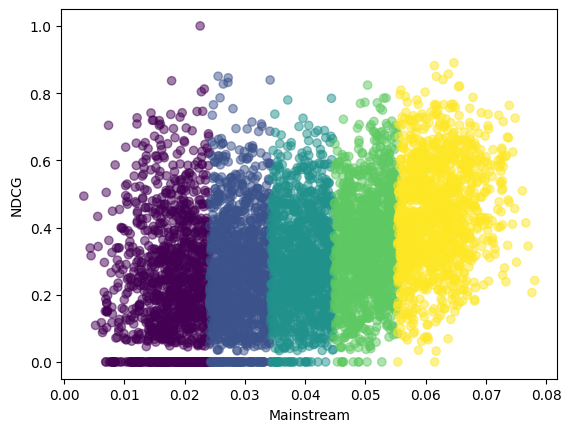

In [20]:
### Convert results to dataframe
### Save the dataframes
df = {"NDCG": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["usrmain"]["NDCG"][group]:
        df["NDCG"].append(t)
    for t in results["usrmain"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["usrmain"]["Ave_mtc"][group]
    for t in results["usrmain"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/user main.csv")

### Generate the plot
plt.scatter(df["metric"], df["NDCG"], c=df["group"], alpha=0.5)
plt.ylabel("NDCG")
plt.xlabel("Mainstream")
plt.show()

In [21]:
### Calculate the pearson correlation
df[np.isnan(df)] = 0
pearsonr(df["metric"], df["NDCG"])

(0.40629033127310543, 7.2601662877386775e-239)

In [22]:
### This and the next following 4 chunks are the average NDCG of the 5 groups
### Similar, for the other plots, these chunks will be average NDCG or MDG for 5 groups
df[df["group"] == 0]["NDCG"].mean()

0.23511668852865494

In [23]:
df[df["group"] == 1]["NDCG"].mean()

0.2662339342726496

In [24]:
df[df["group"] == 2]["NDCG"].mean()

0.2956517969808286

In [25]:
df[df["group"] == 3]["NDCG"].mean()

0.3499776919421689

In [26]:
df[df["group"] == 4]["NDCG"].mean()

0.4436055782253085

In [ ]:
### The following chunks are all for generating plots, they are similar

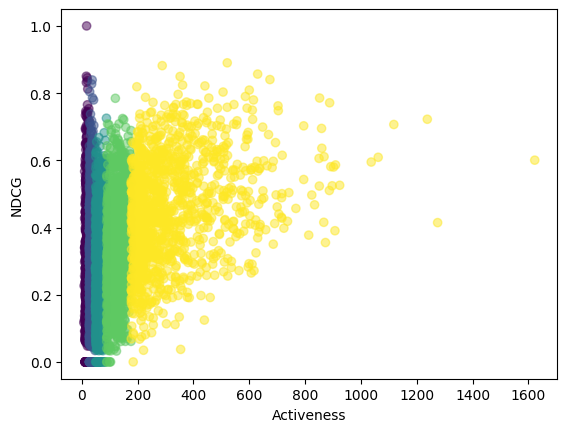

In [34]:
df = {"NDCG": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["activeness"]["NDCG"][group]:
        df["NDCG"].append(t)
    for t in results["activeness"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["activeness"]["Ave_mtc"][group]
    for t in results["activeness"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/user act.csv")
plt.scatter(df["metric"], df["NDCG"], c=df["group"], alpha=0.5)
plt.ylabel("NDCG")
plt.xlabel("Activeness")
plt.show()

In [35]:
df[np.isnan(df)] = 0
pearsonr(df["metric"], df["NDCG"])

(0.4219030564939779, 2.4013578972298174e-259)

In [36]:
df[df["group"] == 0]["NDCG"].mean()

0.23733259251114752

In [37]:
df[df["group"] == 1]["NDCG"].mean()

0.27440413141620607

In [38]:
df[df["group"] == 2]["NDCG"].mean()

0.28191703609485974

In [39]:
df[df["group"] == 3]["NDCG"].mean()

0.33931124712215655

In [40]:
df[df["group"] == 4]["NDCG"].mean()

0.4576206828052407

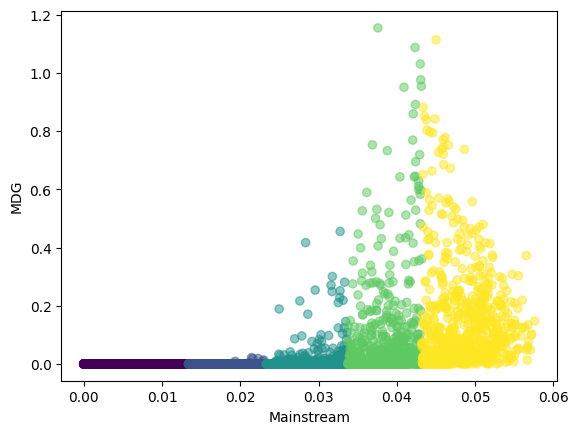

In [41]:
df = {"Performance": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["itmmain"]["Performance"][group]:
        df["Performance"].append(t)
    for t in results["itmmain"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["itmmain"]["Ave_mtc"][group]
    for t in results["itmmain"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/item main.csv")
plt.scatter(df["metric"], df["Performance"], c=df["group"], alpha=0.5)
plt.ylabel("MDG")
plt.xlabel("Mainstream")
plt.show()

In [42]:
pearsonr(df["metric"], df["Performance"])

(0.4242675214239827, 1.1328973710868371e-151)

In [43]:
df[df["group"] == 0]["Performance"].mean()

0.0

In [44]:
df[df["group"] == 1]["Performance"].mean()

0.00013550227945167788

In [45]:
df[df["group"] == 2]["Performance"].mean()

0.010625900729024154

In [46]:
df[df["group"] == 3]["Performance"].mean()

0.07659568333961396

In [47]:
df[df["group"] == 4]["Performance"].mean()

0.14429513642066885

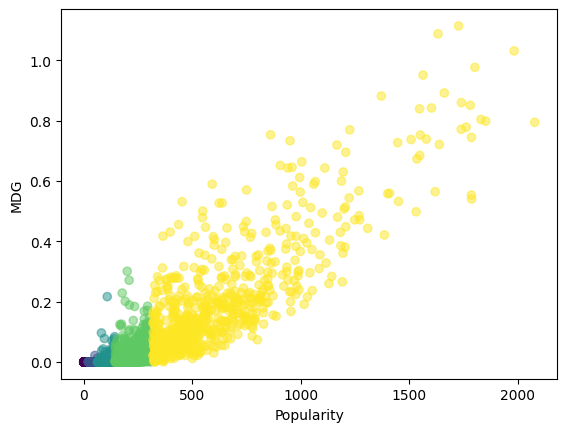

In [48]:
df = {"Performance": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["popularity"]["Performance"][group]:
        df["Performance"].append(t)
    for t in results["popularity"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["popularity"]["Ave_mtc"][group]
    for t in results["popularity"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/item pop.csv")
plt.scatter(df["metric"], df["Performance"], c=df["group"], alpha=0.5)
plt.ylabel("MDG")
plt.xlabel("Popularity")
plt.show()

In [49]:
pearsonr(df["metric"], df["Performance"])

(0.8761569473277464, 0.0)

In [50]:
df[df["group"] == 0]["Performance"].mean()

0.0

In [51]:
df[df["group"] == 1]["Performance"].mean()

4.868562771632235e-05

In [52]:
df[df["group"] == 2]["Performance"].mean()

0.002597876743936899

In [53]:
df[df["group"] == 3]["Performance"].mean()

0.022272524449313817

In [54]:
df[df["group"] == 4]["Performance"].mean()

0.20401621724137217

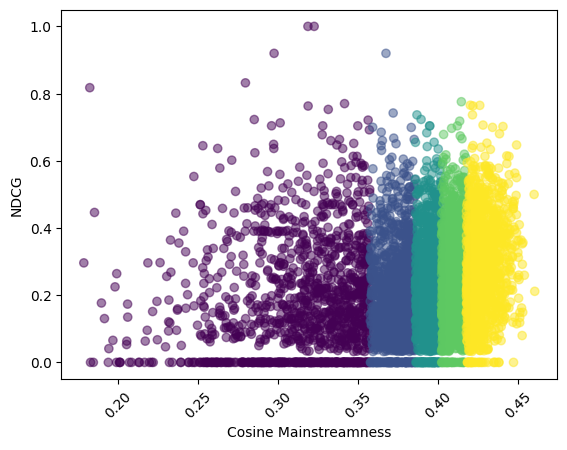

In [58]:
df = {"NDCG": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["usrcos"]["NDCG"][group]:
        df["NDCG"].append(t)
    for t in results["usrcos"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["usrcos"]["Ave_mtc"][group]
    for t in results["usrcos"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/user cosine.csv")
plt.scatter(df["metric"], df["NDCG"], c=df["group"], alpha=0.5)
plt.ylabel("NDCG")
plt.xlabel("Cosine Mainstreamness")
plt.xticks(rotation=45)
plt.show()

In [59]:
df[np.isnan(df)] = 0
pearsonr(df["metric"], df["NDCG"])

(0.22372258176841972, 2.170158649782984e-69)

In [60]:
df[df["group"] == 0]["NDCG"].mean()

0.19063353546522735

In [61]:
df[df["group"] == 1]["NDCG"].mean()

0.2030722725077821

In [62]:
df[df["group"] == 2]["NDCG"].mean()

0.23378615120980684

In [63]:
df[df["group"] == 3]["NDCG"].mean()

0.2569011714301382

In [64]:
df[df["group"] == 4]["NDCG"].mean()

0.29050271559516055

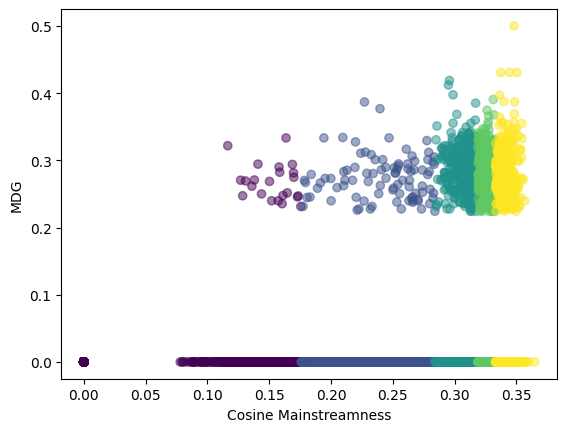

In [65]:
df = {"Performance": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["itmcos"]["Performance"][group]:
        df["Performance"].append(t)
    for t in results["itmcos"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["itmcos"]["Ave_mtc"][group]
    for t in results["itmcos"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/item cos.csv")
plt.scatter(df["metric"], df["Performance"], c=df["group"], alpha=0.5)
plt.ylabel("MDG")
plt.xlabel("Cosine Mainstreamness")
plt.show()

In [66]:
pearsonr(df["metric"], df["Performance"])

(0.3957551518527862, 3.545470784703434e-139)

In [67]:
df[df["group"] == 0]["Performance"].mean()

0.008296931986168706

In [68]:
df[df["group"] == 1]["Performance"].mean()

0.033272446620360795

In [69]:
df[df["group"] == 2]["Performance"].mean()

0.13445882396469822

In [70]:
df[df["group"] == 3]["Performance"].mean()

0.15180510631852379

In [71]:
df[df["group"] == 4]["Performance"].mean()

0.13242219352777274

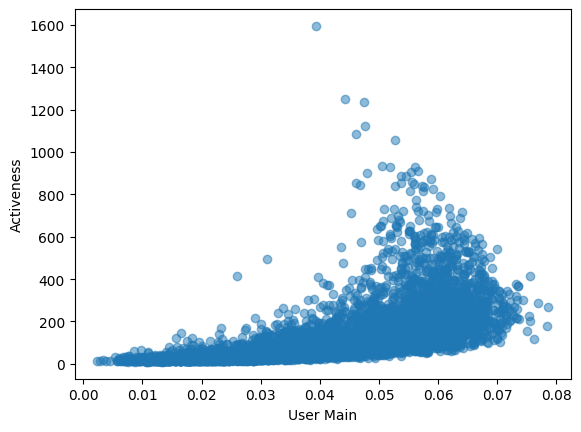

In [109]:
df = {"Activeness": activeness, "User Main": user_mainstreamness}
df = pd.DataFrame(df)
plt.scatter(df["User Main"], df["Activeness"], alpha=0.5)
plt.ylabel("Activeness")
plt.xlabel("User Main")
plt.show()

In [110]:
pearsonr(df["User Main"], df["Activeness"])

(0.6237111997916119, 0.0)

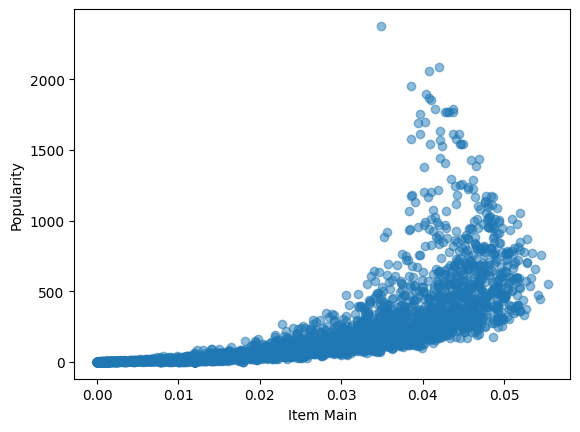

In [111]:
df = {"Popularity": popularity, "Item Main": item_mainstreamness}
df = pd.DataFrame(df)
plt.scatter(df["Item Main"],df["Popularity"], alpha=0.5)
plt.ylabel("Popularity")
plt.xlabel("Item Main")
plt.show()

In [112]:
pearsonr(df["Item Main"],df["Popularity"])

(0.6931139645673442, 0.0)

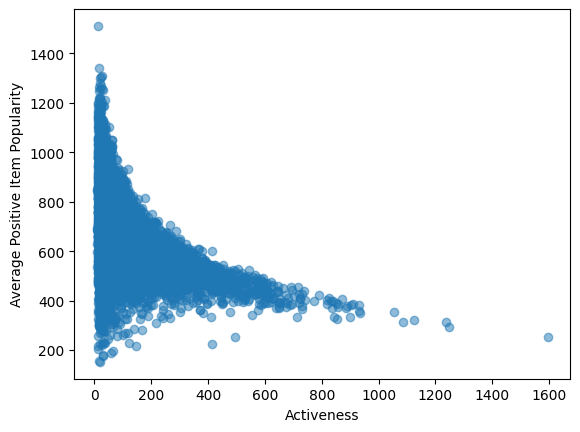

In [113]:
act_pop = []
for t in range(Rec_train.shape[0]):
    idx = [i for i,x in enumerate(Rec_train[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += popularity[tt]
    sum /= len(idx)
    act_pop.append(sum)

df = {"Activeness": activeness, "Ave_pop": act_pop}
df = pd.DataFrame(df)
plt.scatter(df["Activeness"], df["Ave_pop"], alpha=0.5)
plt.ylabel("Average Positive Item Popularity")
plt.xlabel("Activeness")
plt.show()

In [114]:
pearsonr(df["Activeness"], df["Ave_pop"])

(-0.46947657414943755, 0.0)

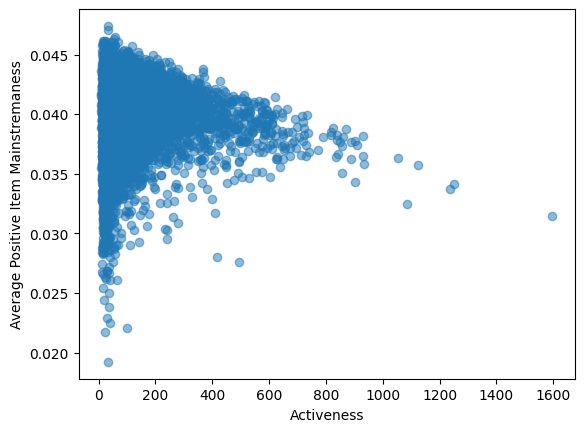

In [115]:
act_main = []
for t in range(Rec_train.shape[0]):
    idx = [i for i,x in enumerate(Rec_train[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += item_mainstreamness[tt]
    sum /= len(idx)
    act_main.append(sum)

df = {"Activeness": activeness, "Ave_main": act_main}
df = pd.DataFrame(df)
plt.scatter(df["Activeness"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive Item Mainstremaness")
plt.xlabel("Activeness")
plt.show()

In [116]:
pearsonr(df["Activeness"], df["Ave_main"])

(0.014263402334110676, 0.26771413737450955)

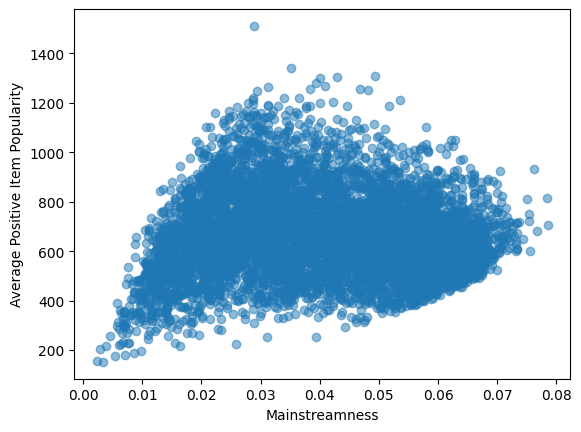

In [117]:
main_pop = []
for t in range(Rec_train.shape[0]):
    idx = [i for i,x in enumerate(Rec_train[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += popularity[tt]
    sum /= len(idx)
    main_pop.append(sum)

df = {"Mainstreamness": user_mainstreamness, "Ave_pop": main_pop}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_pop"], alpha=0.5)
plt.ylabel("Average Positive Item Popularity")
plt.xlabel("Mainstreamness")
plt.show()

In [118]:
pearsonr(df["Mainstreamness"], df["Ave_pop"])

(0.013309457005258603, 0.3010386545476253)

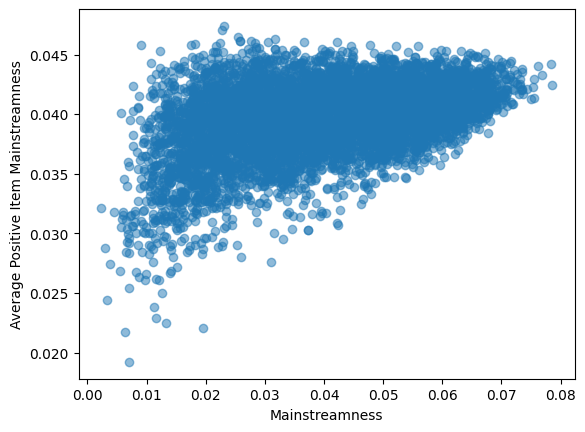

In [119]:
main_main = []
for t in range(Rec_train.shape[0]):
    idx = [i for i,x in enumerate(Rec_train[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += item_mainstreamness[tt]
    sum /= len(idx)
    main_main.append(sum)

df = {"Mainstreamness": user_mainstreamness, "Ave_main": main_main}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive Item Mainstreamness")
plt.xlabel("Mainstreamness")
plt.show()

In [120]:
pearsonr(df["Mainstreamness"], df["Ave_main"])

(0.4309782987977978, 9.264311295779618e-272)

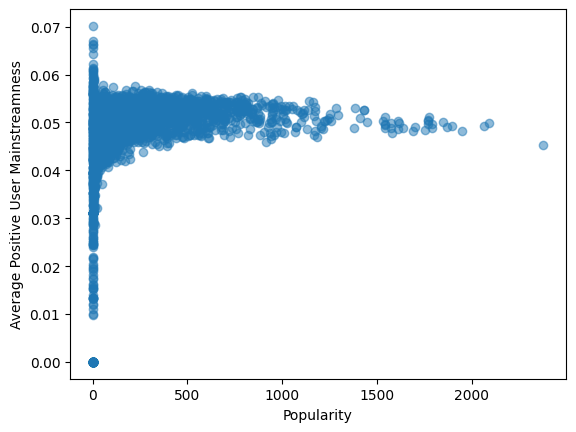

In [121]:
pop_main = []
for t in range(Rec_train_item.shape[0]):
    idx = [i for i,x in enumerate(Rec_train_item[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += user_mainstreamness[tt]
    if len(idx) != 0:
        sum /= len(idx)
    pop_main.append(sum)

df = {"Popularity": popularity, "Ave_main": pop_main}
df = pd.DataFrame(df)
plt.scatter(df["Popularity"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive User Mainstreamness")
plt.xlabel("Popularity")
plt.show()

In [122]:
pearsonr(df["Popularity"], df["Ave_main"])

(0.2427873001904271, 7.326809860355618e-51)

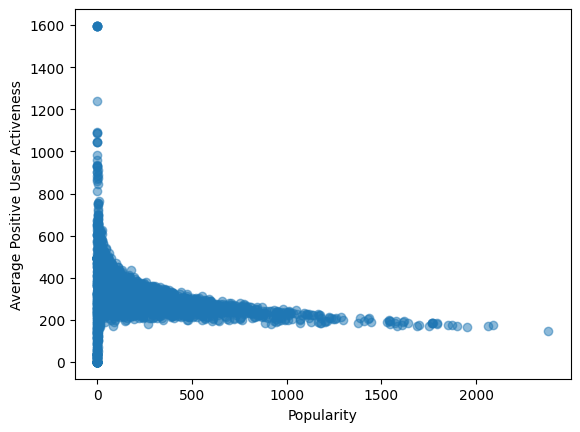

In [123]:
pop_act = []
for t in range(Rec_train_item.shape[0]):
    idx = [i for i,x in enumerate(Rec_train_item[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += activeness[tt]
    if len(idx) != 0:
        sum /= len(idx)
    pop_act.append(sum)

df = {"Popularity": popularity, "Ave_act": pop_act}
df = pd.DataFrame(df)
plt.scatter(df["Popularity"], df["Ave_act"], alpha=0.5)
plt.ylabel("Average Positive User Activeness")
plt.xlabel("Popularity")
plt.show()

In [124]:
pearsonr(df["Popularity"], df["Ave_act"])

(-0.3379804914467983, 1.0604078299576217e-99)

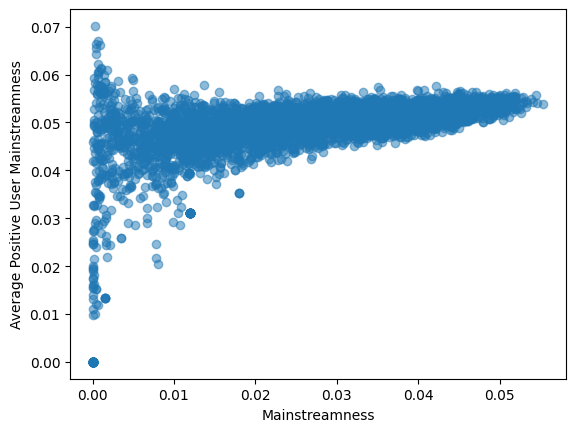

In [126]:
main_main = []
for t in range(Rec_train_item.shape[0]):
    idx = [i for i,x in enumerate(Rec_train_item[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += user_mainstreamness[tt]
    if len(idx) != 0:
        sum /= len(idx)
    main_main.append(sum)

df = {"Mainstreamness": item_mainstreamness, "Ave_main": main_main}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive User Mainstreamness")
plt.xlabel("Mainstreamness")
plt.show()

In [127]:
pearsonr(df["Mainstreamness"], df["Ave_main"])

(0.5014591394927722, 2.8962247618599352e-235)

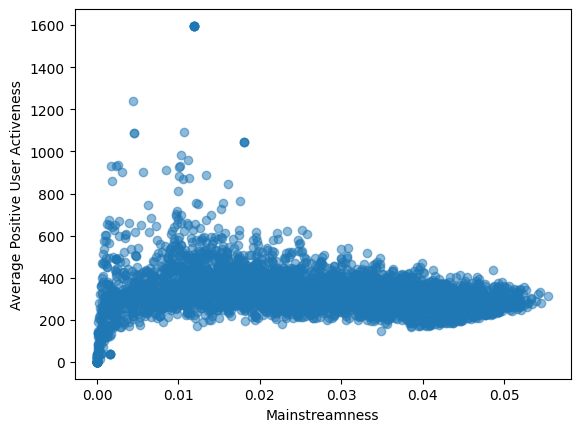

In [128]:
main_act = []
for t in range(Rec_train_item.shape[0]):
    idx = [i for i,x in enumerate(Rec_train_item[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += activeness[tt]
    if len(idx) != 0:
        sum /= len(idx)
    main_act.append(sum)

df = {"Mainstreamness": item_mainstreamness, "Ave_act": main_act}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_act"], alpha=0.5)
plt.ylabel("Average Positive User Activeness")
plt.xlabel("Mainstreamness")
plt.show()

In [129]:
pearsonr(df["Mainstreamness"], df["Ave_act"])

(-0.1449907655544765, 7.280231719814169e-19)

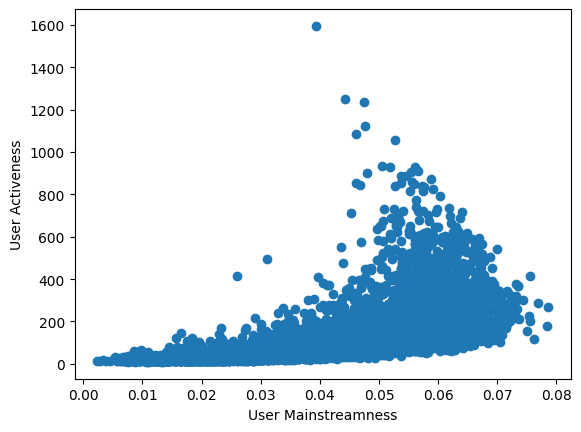

In [130]:
df = {"User Mainstreamness": user_mainstreamness, "User Activeness": activeness}
df = pd.DataFrame(df)
plt.scatter(df["User Mainstreamness"], df["User Activeness"])
plt.ylabel("User Activeness")
plt.xlabel("User Mainstreamness")
plt.show()

In [131]:
pearsonr(df["User Mainstreamness"], df["User Activeness"])

(0.6237111997916119, 0.0)

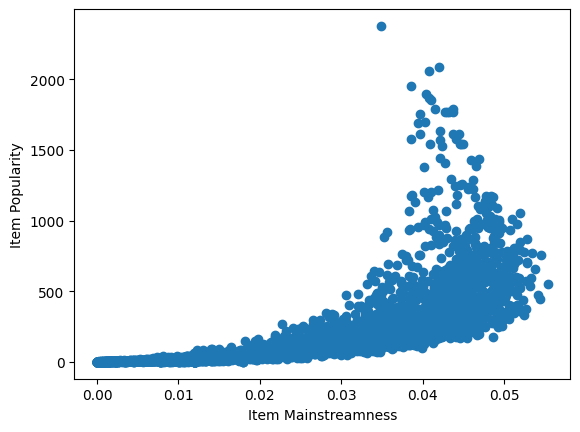

In [132]:
df = {"Item Mainstreamness": item_mainstreamness, "Item Popularity": popularity}
df = pd.DataFrame(df)
plt.scatter(df["Item Mainstreamness"], df["Item Popularity"])
plt.ylabel("Item Popularity")
plt.xlabel("Item Mainstreamness")
plt.show()

In [133]:
pearsonr(df["Item Mainstreamness"], df["Item Popularity"])

(0.6931139645673442, 0.0)

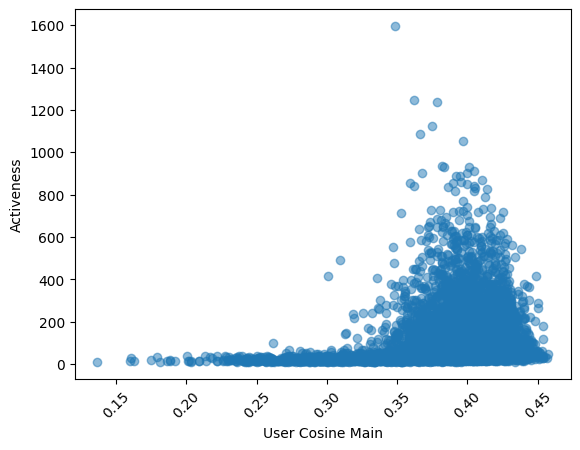

In [65]:
df = {"Activeness": activeness, "User Main": cos_similar}
df = pd.DataFrame(df)
plt.scatter(df["User Main"], df["Activeness"], alpha=0.5)
plt.ylabel("Activeness")
plt.xlabel("User Cosine Main")
plt.xticks(rotation=45)
plt.show()

In [66]:
pearsonr(df["User Main"], df["Activeness"])

(0.23648289553385937, 1.5214311729578575e-77)

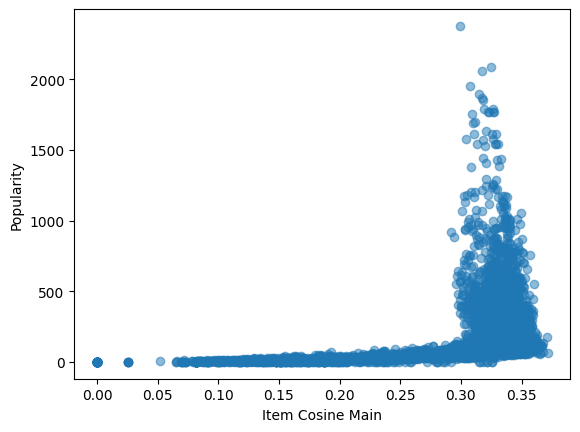

In [67]:
df = {"Popularity": popularity, "Item Main": cos_similar_item}
df = pd.DataFrame(df)
plt.scatter(df["Item Main"],df["Popularity"], alpha=0.5)
plt.ylabel("Popularity")
plt.xlabel("Item Cosine Main")
plt.show()

In [68]:
pearsonr(df["Item Main"],df["Popularity"])

(0.4411844799776532, 2.3031062305994983e-176)

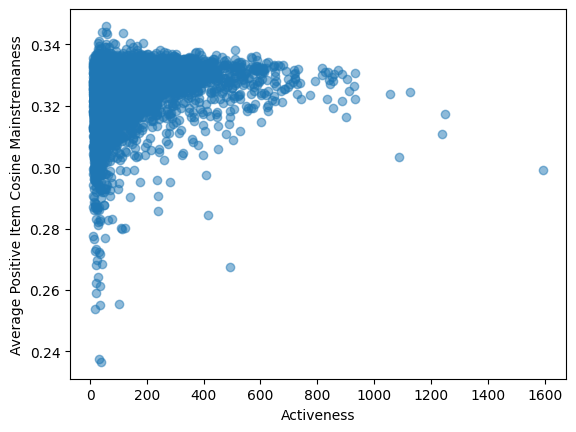

In [69]:
act_main = []
for t in range(Rec_train.shape[0]):
    idx = [i for i,x in enumerate(Rec_train[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += cos_similar_item[tt]
    sum /= len(idx)
    act_main.append(sum)

df = {"Activeness": activeness, "Ave_main": act_main}
df = pd.DataFrame(df)
plt.scatter(df["Activeness"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive Item Cosine Mainstremaness")
plt.xlabel("Activeness")
plt.show()

In [70]:
pearsonr(df["Activeness"], df["Ave_main"])

(0.2731420143274789, 8.196928741701036e-104)

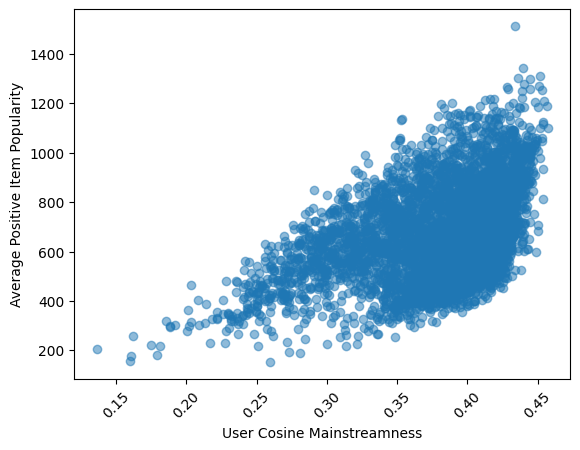

In [71]:
main_pop = []
for t in range(Rec_train.shape[0]):
    idx = [i for i,x in enumerate(Rec_train[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += popularity[tt]
    sum /= len(idx)
    main_pop.append(sum)

df = {"Mainstreamness": cos_similar, "Ave_pop": main_pop}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_pop"], alpha=0.5)
plt.ylabel("Average Positive Item Popularity")
plt.xlabel("User Cosine Mainstreamness")
plt.xticks(rotation=45)
plt.show()

In [72]:
pearsonr(df["Mainstreamness"], df["Ave_pop"])

(0.45831948205814255, 1.5561104156217e-311)

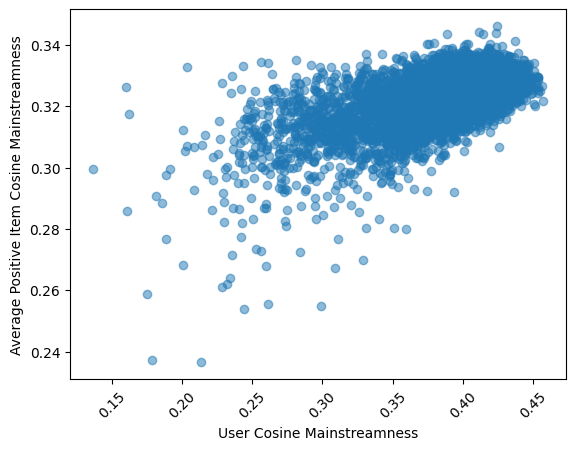

In [73]:
main_main = []
for t in range(Rec_train.shape[0]):
    idx = [i for i,x in enumerate(Rec_train[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += cos_similar_item[tt]
    sum /= len(idx)
    main_main.append(sum)

df = {"Mainstreamness": cos_similar, "Ave_main": main_main}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive Item Cosine Mainstreamness")
plt.xlabel("User Cosine Mainstreamness")
plt.xticks(rotation=45)
plt.show()

In [74]:
pearsonr(df["Mainstreamness"], df["Ave_main"])

(0.6237050951593605, 0.0)

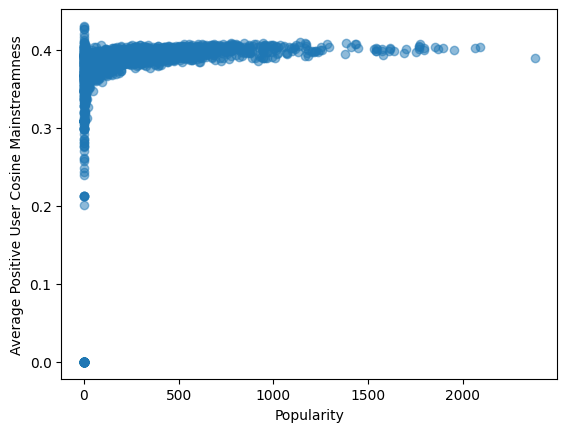

In [75]:
pop_main = []
for t in range(Rec_train_item.shape[0]):
    idx = [i for i,x in enumerate(Rec_train_item[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += cos_similar[tt]
    if len(idx) != 0:
        sum /= len(idx)
    pop_main.append(sum)

df = {"Popularity": popularity, "Ave_main": pop_main}
df = pd.DataFrame(df)
plt.scatter(df["Popularity"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive User Cosine Mainstreamness")
plt.xlabel("Popularity")
plt.show()

In [76]:
pearsonr(df["Popularity"], df["Ave_main"])

(0.23979160509711617, 1.273227523762822e-49)

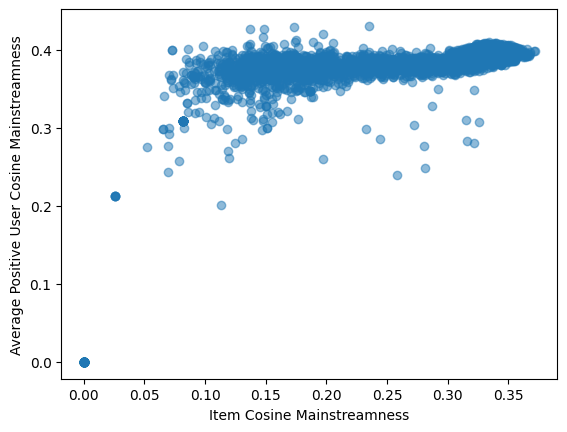

In [77]:
main_main = []
for t in range(Rec_train_item.shape[0]):
    idx = [i for i,x in enumerate(Rec_train_item[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += cos_similar[tt]
    if len(idx) != 0:
        sum /= len(idx)
    main_main.append(sum)

df = {"Mainstreamness": cos_similar_item, "Ave_main": main_main}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive User Cosine Mainstreamness")
plt.xlabel("Item Cosine Mainstreamness")
plt.show()

In [78]:
pearsonr(df["Mainstreamness"], df["Ave_main"])

(0.5676999143019926, 2.914612927e-315)

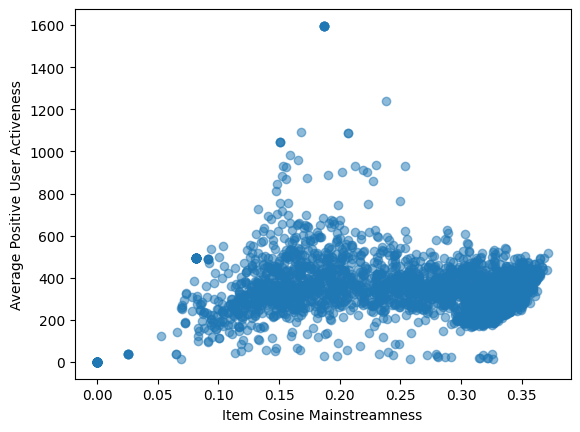

In [79]:
main_act = []
for t in range(Rec_train_item.shape[0]):
    idx = [i for i,x in enumerate(Rec_train_item[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += activeness[tt]
    if len(idx) != 0:
        sum /= len(idx)
    main_act.append(sum)

df = {"Mainstreamness": cos_similar_item, "Ave_act": main_act}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_act"], alpha=0.5)
plt.ylabel("Average Positive User Activeness")
plt.xlabel("Item Cosine Mainstreamness")
plt.show()

In [80]:
pearsonr(df["Mainstreamness"], df["Ave_act"])

(-0.03622076124576501, 0.027454921165790437)

In [ ]:
### Calculate cosine similarity from the original embeddings from Rec
### We calculated the cosine similarity based on new row vectors, this is from the old vectors

In [8]:
### Directly use matrix Rec here
cosine = Rec.dot(Rec.T)
l2 = np.sqrt(np.sum(Rec * Rec, axis = 1))
l2 = l2.reshape([l2.shape[0],1])
cosine = cosine / l2.dot(l2.T)

Rec_item = Rec.T
cosine_item = Rec_item.dot(Rec_item.T)
l2 = np.sqrt(np.sum(Rec_item * Rec_item, axis = 1))
l2 = l2.reshape([l2.shape[0],1])
cosine_item /= l2.dot(l2.T)
cosine_item[np.isnan(cosine_item)] = 0

In [9]:
for i in range(cosine.shape[0]):
    cosine[i][i] = 0
cos_similar = []
for t in range(cosine.shape[0]):
    cos_similar.append(sum(cosine[t])/cosine.shape[0])
cos_similar = np.array(cos_similar)

for i in range(cosine_item.shape[0]):
    cosine_item[i][i] = 0
cos_similar_item = []
for t in range(cosine_item.shape[0]):
    cos_similar_item.append(sum(cosine_item[t])/cosine_item.shape[0])
cos_similar_item = np.array(cos_similar_item)

In [10]:
cos_sort = (np.sort(cos_similar), np.argsort(cos_similar))
cos_sort_item = (np.sort(cos_similar_item), np.argsort(cos_similar_item))

In [23]:
### Still, put all results into a single dict result
### K is the number of groups
idx_ = []
k = 5
results = {"usrmain":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "activeness":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "usrcos":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]},
           "itmmain":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "popularity":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "itmcos":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}}
num_user = Rec.shape[0]
bt_user = int(num_user/k)
num_item = Rec.shape[1]
bt_item = int(num_item/k)
for i in range(k):
    results["usrmain"]["NDCG"].append(NDCG[usrmain_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrmain"]["Ave_rank"].append(Ave_rank_user[usrmain_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrmain"]["Ave_mtc"].append(np.mean(usrmain_sort[0][i*bt_user:(i+1)*bt_user]))
    results["usrmain"]["Metric"].append(usrmain_sort[0][i*bt_user:(i+1)*bt_user])
    results["activeness"]["NDCG"].append(NDCG[act_sort[1][i*bt_user:(i+1)*bt_user]])
    results["activeness"]["Ave_rank"].append(Ave_rank_user[act_sort[1][i*bt_user:(i+1)*bt_user]])
    results["activeness"]["Ave_mtc"].append(np.mean(act_sort[0][i*bt_user:(i+1)*bt_user]))
    results["activeness"]["Metric"].append(act_sort[0][i*bt_user:(i+1)*bt_user])
    results["usrcos"]["NDCG"].append(NDCG[cos_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrcos"]["Ave_rank"].append(Ave_rank_user[cos_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrcos"]["Ave_mtc"].append(np.mean(cos_sort[0][i*bt_user:(i+1)*bt_user]))
    results["usrcos"]["Metric"].append(cos_sort[0][i*bt_user:(i+1)*bt_user])
    
    results["itmmain"]["Performance"].append(Performance[itmmain_sort[1][i*bt_item:(i+1)*bt_item]])
    results["itmmain"]["Ave_rank"].append(Ave_rank_item[itmmain_sort[1][i*bt_item:(i+1)*bt_item]])
    results["itmmain"]["Ave_mtc"].append(np.mean(itmmain_sort[0][i*bt_item:(i+1)*bt_item]))
    results["itmmain"]["Metric"].append(itmmain_sort[0][i*bt_item:(i+1)*bt_item])
    results["popularity"]["Performance"].append(Performance[pop_sort[1][i*bt_item:(i+1)*bt_item]])
    results["popularity"]["Ave_rank"].append(Ave_rank_item[pop_sort[1][i*bt_item:(i+1)*bt_item]])
    results["popularity"]["Ave_mtc"].append(np.mean(pop_sort[0][i*bt_item:(i+1)*bt_item]))
    results["popularity"]["Metric"].append(pop_sort[0][i*bt_item:(i+1)*bt_item])
    results["itmcos"]["Performance"].append(Performance[cos_sort_item[1][i*bt_item:(i+1)*bt_item]])
    results["itmcos"]["Ave_rank"].append(Ave_rank_item[cos_sort_item[1][i*bt_item:(i+1)*bt_item]])
    results["itmcos"]["Ave_mtc"].append(np.mean(cos_sort_item[0][i*bt_item:(i+1)*bt_item]))
    results["itmcos"]["Metric"].append(cos_sort_item[0][i*bt_item:(i+1)*bt_item])

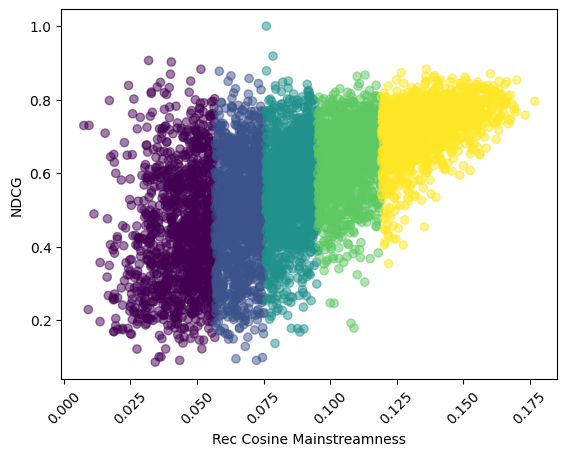

In [24]:
df = {"NDCG": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["usrcos"]["NDCG"][group]:
        df["NDCG"].append(t)
    for t in results["usrcos"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["usrcos"]["Ave_mtc"][group]
    for t in results["usrcos"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/user cosine.csv")
plt.scatter(df["metric"], df["NDCG"], c=df["group"], alpha=0.5)
plt.ylabel("NDCG")
plt.xlabel("Rec Cosine Mainstreamness")
plt.xticks(rotation=45)
plt.show()

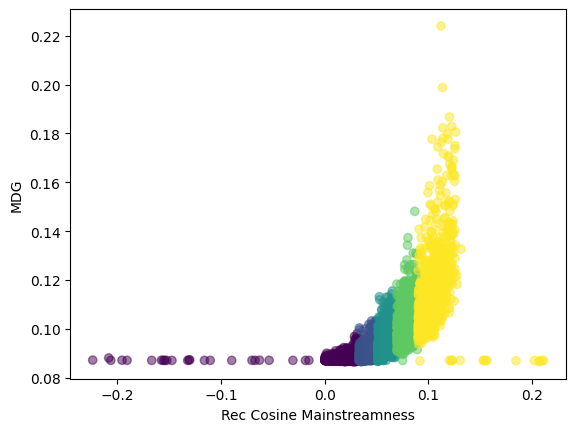

In [25]:
df = {"Performance": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["itmcos"]["Performance"][group]:
        df["Performance"].append(t)
    for t in results["itmcos"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["itmcos"]["Ave_mtc"][group]
    for t in results["itmcos"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/item cos.csv")
plt.scatter(df["metric"], df["Performance"], c=df["group"], alpha=0.5)
plt.ylabel("MDG")
plt.xlabel("Rec Cosine Mainstreamness")
plt.show()